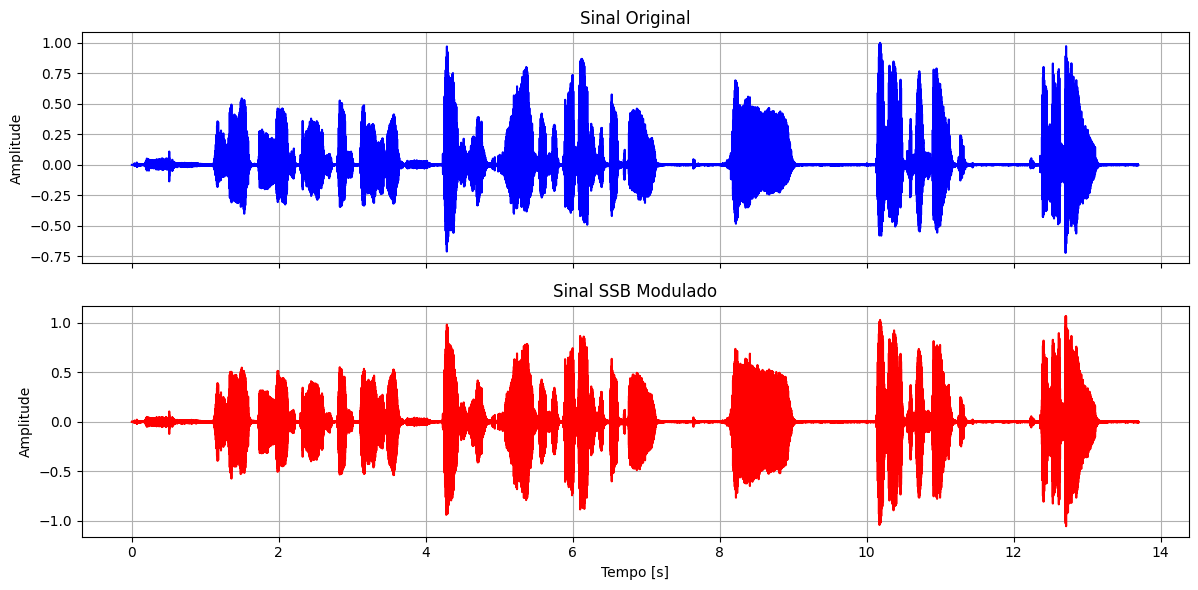

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 1. CARREGAR O ÁUDIO (gravado pelo celular)
audio_path = "Teste-pcom.wav"  # insira o caminho correto do seu áudio
x, fs = sf.read(audio_path)
if x.ndim > 1:
    x = x.mean(axis=1)  # faz a média dos canais (mono)
    # x = x[:, 0]  # (alternativa) usa apenas o primeiro canal (esquerdo)
#x = x[:min(len(x), 5*fs)]  # limitar para 5 segundos (opcional)
x = x / np.max(np.abs(x))  # normalizar

# 2. DEFINIÇÃO DOS PARÂMETROS DE MODULAÇÃO
fc = 10000  # Frequência da portadora (10 kHz)
t = np.arange(len(x)) / fs  # vetor de tempo

# 3. GERAR ENVOLTÓRIA ANALÍTICA DO SINAL (Transformada de Hilbert)
x_analitico = hilbert(x)
x_ssb = np.real(x_analitico * np.exp(1j * 2 * np.pi * fc * t))  # SSB-USB

# 4. SALVAR SINAL MODULADO
modulado_path = "sinal_modulado_ssb.wav"
sf.write(modulado_path, x_ssb, fs)

# 5. VISUALIZAÇÃO (opcional)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
#axs[0].plot(t[:1000], x[:1000], color='b')
axs[0].plot(t, x, color='b')
axs[0].set_title('Sinal Original')
axs[0].set_ylabel('Amplitude')
axs[0].grid()
#axs[1].plot(t[:1000], x_ssb[:1000], color='r')
axs[1].plot(t, x_ssb, color='r')
axs[1].set_title('Sinal SSB Modulado')
axs[1].set_xlabel('Tempo [s]')
axs[1].set_ylabel('Amplitude')
axs[1].grid()
plt.tight_layout()
plt.show()


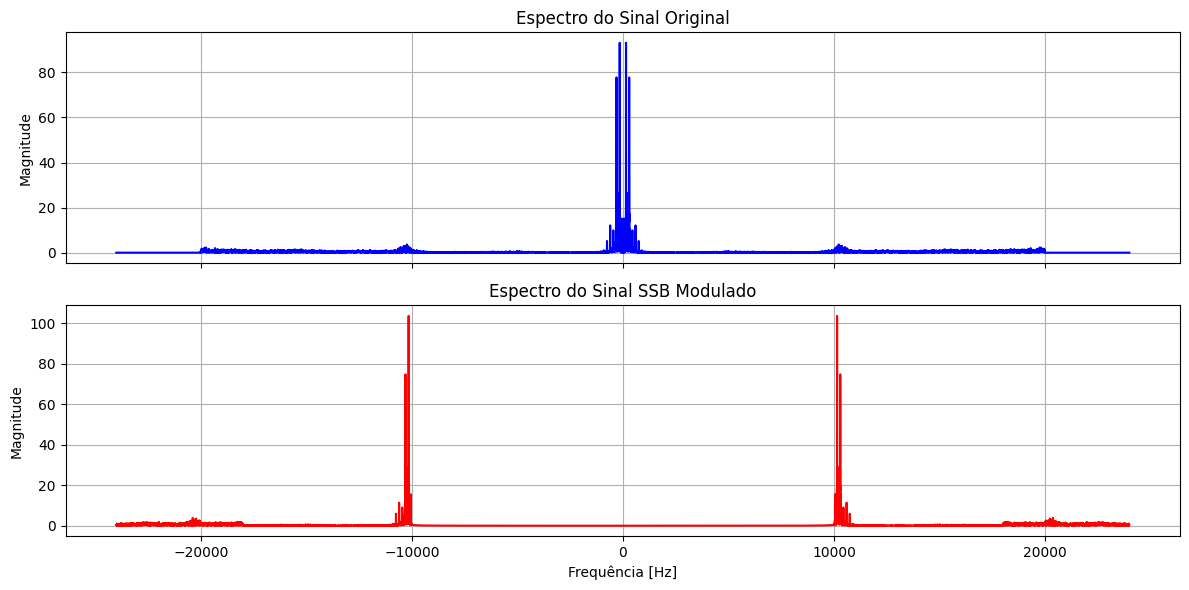

In [2]:
# Espectro de frequência do sinal original e do sinal SSB modulado
from numpy.fft import fft, fftfreq, fftshift
N = 20000  # número de pontos para o espectro
X = fft(x[:N])
X_ssb = fft(x_ssb[:N])
freqs = fftshift(fftfreq(N, 1/fs))
X_mag = fftshift(np.abs(X))
X_ssb_mag = fftshift(np.abs(X_ssb))

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(freqs, X_mag, color='b')
axs[0].set_title('Espectro do Sinal Original')
axs[0].set_ylabel('Magnitude')
axs[0].grid()
axs[1].plot(freqs, X_ssb_mag, color='r')
axs[1].set_title('Espectro do Sinal SSB Modulado')
axs[1].set_xlabel('Frequência [Hz]')
axs[1].set_ylabel('Magnitude')
axs[1].grid()
plt.tight_layout()
plt.show()

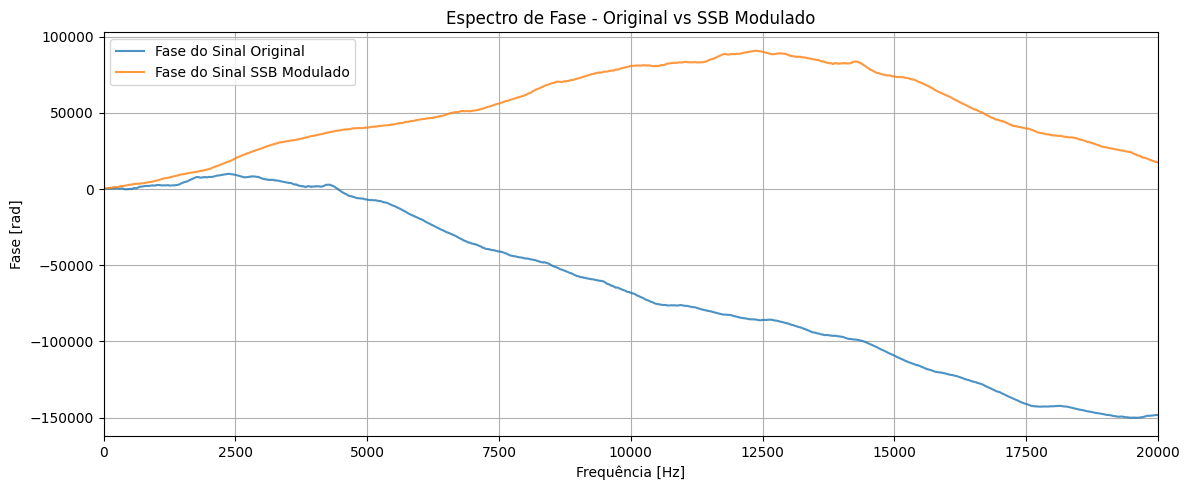

In [35]:
from scipy.fft import fft, fftfreq

# 1. Parâmetros para a FFT
N = len(x)
freqs = fftfreq(N, d=1/fs)

# 2. FFT dos sinais
X = fft(x)
X_mod = fft(x_ssb)

# 3. Fase (unwrap para continuidade)
fase_X = np.unwrap(np.angle(X))
fase_X_mod = np.unwrap(np.angle(X_mod))

# 4. Máscara para frequência positiva
pos = freqs > 0
freqs_pos = freqs[pos]

# 5. Plotagem
plt.figure(figsize=(12, 5))
plt.plot(freqs_pos, fase_X[pos], label='Fase do Sinal Original', alpha=0.8)
plt.plot(freqs_pos, fase_X_mod[pos], label='Fase do Sinal SSB Modulado', alpha=0.8)
plt.title("Espectro de Fase - Original vs SSB Modulado")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Fase [rad]")
plt.grid()
plt.legend()
plt.xlim(0, 20000)  # zoom até 20 kHz
plt.tight_layout()
plt.show()


In [ ]:
#Demodulação

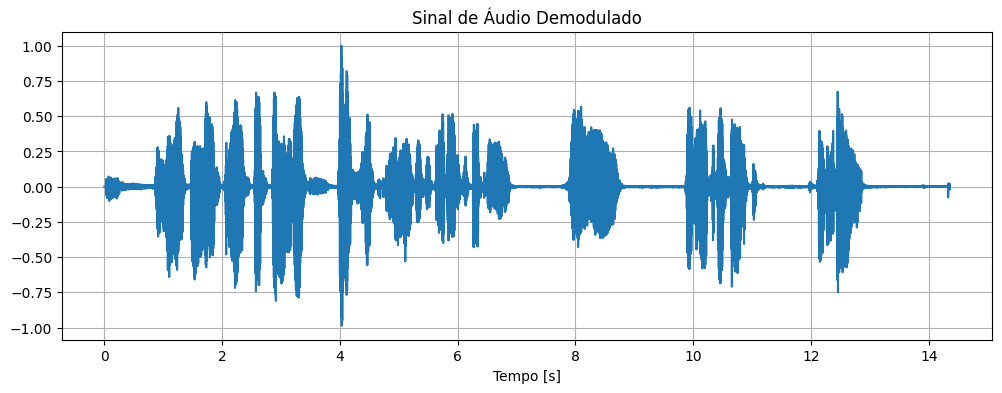

In [36]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert

# 1. Carregar o arquivo gravado via microfone
arquivo_ssb = "Teste_pt2.wav"
y, fs = sf.read(arquivo_ssb)

# Se estéreo, usar apenas 1 canal
if len(y.shape) > 1:
    #y = y[:, 0]
    y = np.mean(y, axis=1)  # média dos canais esquerdo e direito

# Normalizar
y = y / np.max(np.abs(y))

# 2. Definir parâmetros
fc = 10000  # Frequência da portadora (10 kHz)
t = np.arange(len(y)) / fs

# 3. Demodulação coerente (produto com portadora e filtragem passa-baixa)

# Mistura com cosseno (reintroduz a portadora)
produto = y * 2 * np.cos(2 * np.pi * fc * t)

# 4. Filtro passa-baixa
def butter_lowpass(cutoff, fs, order=5):
    nyq = fs / 2
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return b, a

def aplicar_filtro_lp(signal, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return lfilter(b, a, signal)

# Aplicar filtro com frequência de corte de 5 kHz (voz)
demodulado = aplicar_filtro_lp(produto, cutoff=5000, fs=fs)

# Normalizar e salvar
demodulado = demodulado / np.max(np.abs(demodulado))
sf.write("audio_recuperado3.wav", demodulado, fs)

# 5. Visualização (opcional)
plt.figure(figsize=(12,4))
#plt.plot(t[:2000], demodulado[:2000])
plt.plot(t, demodulado)
plt.title("Sinal de Áudio Demodulado")
plt.xlabel("Tempo [s]")
plt.grid()
plt.show()


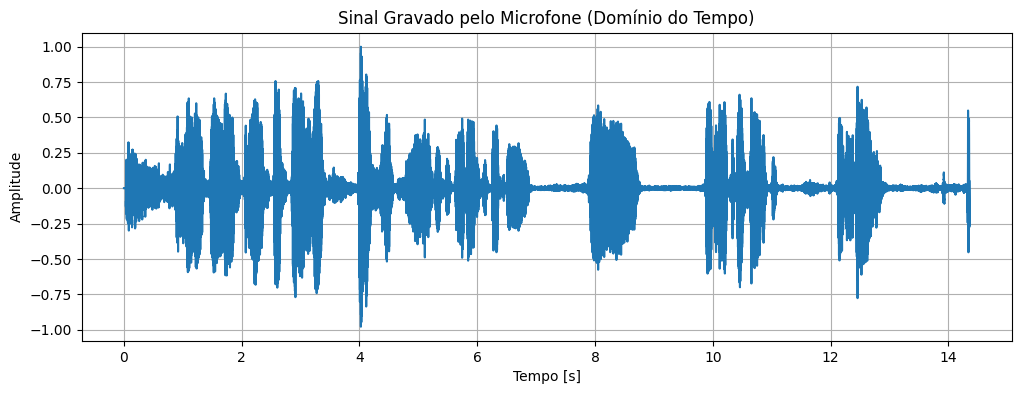

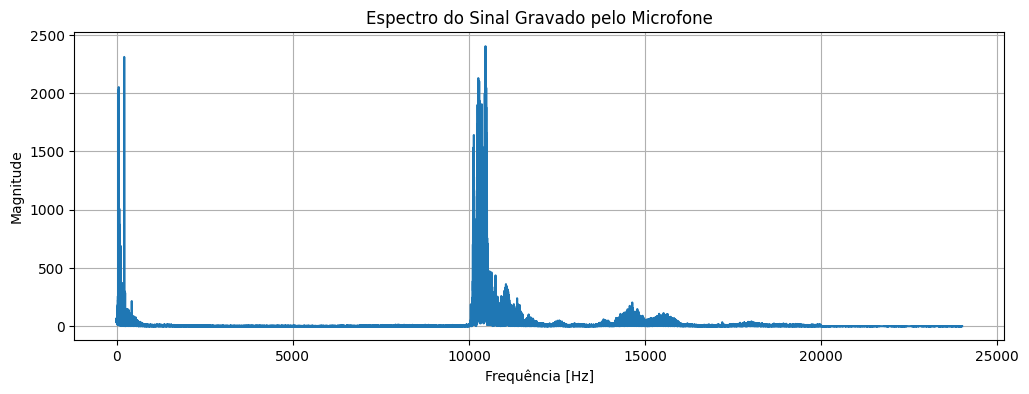

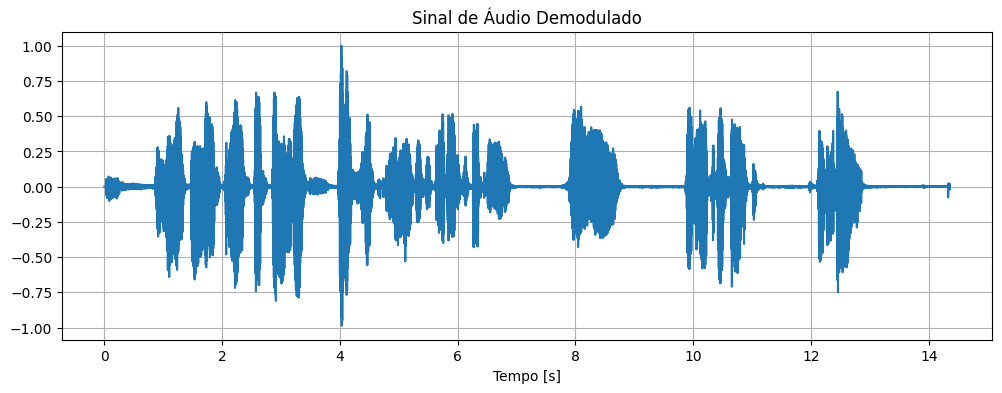

In [3]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert
from scipy.fft import fft, fftfreq

# 1. Carregar o arquivo gravado via microfone
arquivo_ssb = "Teste_pt2.wav"
y, fs = sf.read(arquivo_ssb)

# Se estéreo, usar a média dos canais
if len(y.shape) > 1:
    y = np.mean(y, axis=1)

# Normalizar
y = y / np.max(np.abs(y))

# Criar vetor de tempo
t = np.arange(len(y)) / fs

# --- PLOTAR O SINAL GRAVADO ---
plt.figure(figsize=(12, 4))
plt.plot(t, y)
plt.title("Sinal Gravado pelo Microfone (Domínio do Tempo)")
plt.xlabel("Tempo [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# --- PLOTAR O ESPECTRO DO SINAL GRAVADO ---
N = len(y)
Y = np.abs(fft(y))
freqs = fftfreq(N, d=1/fs)

plt.figure(figsize=(12, 4))
plt.plot(freqs[:N//2], Y[:N//2])  # apenas parte positiva do espectro
plt.title("Espectro do Sinal Gravado pelo Microfone")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

# Continuação do seu código...

# 2. Definir parâmetros
fc = 10000  # Frequência da portadora (10 kHz)

# 3. Demodulação coerente
produto = y * 2 * np.cos(2 * np.pi * fc * t)

# 4. Filtro passa-baixa
def butter_lowpass(cutoff, fs, order=5):
    nyq = fs / 2
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return b, a

def aplicar_filtro_lp(signal, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return lfilter(b, a, signal)

# Aplicar filtro com frequência de corte de 5 kHz
demodulado = aplicar_filtro_lp(produto, cutoff=5000, fs=fs)

# Normalizar e salvar
demodulado = demodulado / np.max(np.abs(demodulado))
sf.write("audio_recuperado3.wav", demodulado, fs)

# Visualização do sinal demodulado
plt.figure(figsize=(12, 4))
plt.plot(t, demodulado)
plt.title("Sinal de Áudio Demodulado")
plt.xlabel("Tempo [s]")
plt.grid()
plt.show()


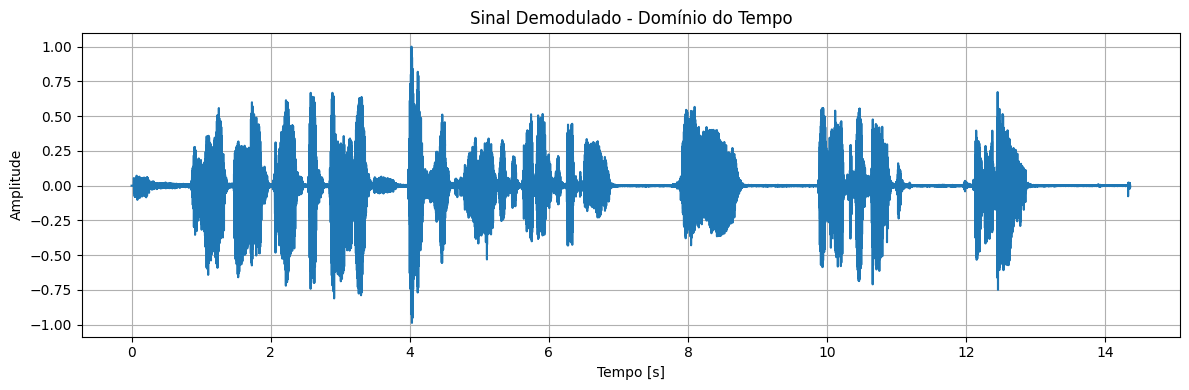

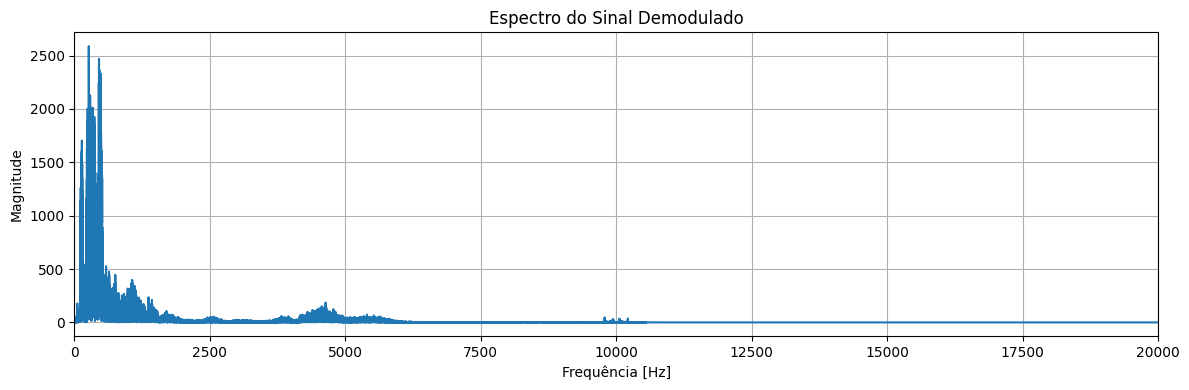

In [37]:
from scipy.fft import fft, fftfreq  # Importa funções para FFT e frequências

# 1. Sinal no tempo (já foi carregado como `demodulado`)
plt.figure(figsize=(12, 4))  # Cria figura para o gráfico do tempo
#plt.plot(t[:3000], demodulado[:3000])  # (opcional) plota só um trecho
plt.plot(t, demodulado)  # Plota o sinal demodulado no tempo

plt.title("Sinal Demodulado - Domínio do Tempo")  # Título do gráfico
plt.xlabel("Tempo [s]")  # Rótulo do eixo x
plt.ylabel("Amplitude")  # Rótulo do eixo y
plt.grid()  # Adiciona grade
plt.tight_layout()  # Ajusta layout
plt.show()  # Exibe o gráfico

# 2. Espectro de frequência
N = len(demodulado)  # Número de pontos do sinal
demodulado_fft = fft(demodulado)  # Calcula a FFT do sinal demodulado
freqs = fftfreq(N, d=1/fs)  # Calcula o vetor de frequências

# Apenas parte positiva
pos_mask = freqs > 0  # Máscara para frequências positivas
freqs_pos = freqs[pos_mask]  # Frequências positivas
fft_magnitude = np.abs(demodulado_fft[pos_mask])  # Magnitude da FFT

# Plot
plt.figure(figsize=(12, 4))  # Cria figura para o espectro
plt.plot(freqs_pos, fft_magnitude)  # Plota o espectro de magnitude
plt.title("Espectro do Sinal Demodulado")  # Título do gráfico
plt.xlabel("Frequência [Hz]")  # Rótulo do eixo x
plt.ylabel("Magnitude")  # Rótulo do eixo y
plt.grid()  # Adiciona grade
plt.xlim([0, 20000])  # zoom até 20 kHz (voz)
plt.tight_layout()  # Ajusta layout
plt.show()  # Exibe o gráfico
